## Develop a Chatbot using NLTK & Tensorflow

In [1]:
# Run this cell so you do not see GPU availibility errors from tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Import Required Libraries

In [2]:
import json
import pickle
import random

import nltk
from nltk.stem import WordNetLemmatizer

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Activation, Dropout

import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
with open(r'intents.json') as data:
    intents = json.loads(data.read())# code here

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Tokenization

We will need to perform numerous preprocessing steps before developing a ml model while working with text data. Lets first iterate through the patterns, tokenize the sentences using word_tokenize function, and enter each word into the words list. Additionally, we'll keep a list of classes for our tags and list of tuples that will contain words against each class tag.

In [4]:
words = []
classes = []
documents = []


for intent in intents['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        classes.append(intent['tag'])
        documents.append((w, intent['tag']))

## Lemmatization

Next, we will need to lowercase and lemmatize each word in words, while ignoring exclamation and question marks (!, ?) that come up. We will also eliminate duplicates from both the words and classes list. Then we will construct a pickle file to carry the sorted Python objects that will be used for prediction.

In [5]:
lemmatizer = WordNetLemmatizer()
ignore_words = ['?', '!']
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))


pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

## Create Data for Training

We will produce training data, which will include the input and output. The pattern will be our input, and our output will be the class to which our pattern belongs. Since machine cannnot understand English, we'll have to convert words to numbers. For that purpose, we'll maintain a list of lits, where the length of each list will be equal to the total number of words, and where the presence of a word in the current pattern be marksed as 1 and its absence will be marked as 0.

In [6]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower())
    for word in pattern_words]
    for w in words:
        if w in pattern_words:
            bag.append(1)
        else: bag.append(0)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])


random.shuffle(training)
a = int(0.7*len(training))
training = np.array(training, dtype = 'object')
X_train = list(training[:a, 0])
y_train = list(training[:a, 1])
X_val = list(training[a:, 0])
y_val = list(training[a:, 1])




## Designing the Model

Constructing a three-layer-deep neural network.  
* first dense layer will have 128 neurons with a rectified linear activation (ReLU) and 50% dropout
* second dense layer will have 64 neurons with ReLU and 50% dropout
* third and final dense layer will have neurons that are equal to the number of intents used to predict output intent with softmax.

In [7]:
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train[0]), activation='softmax'))

## Train and Save the Model

compile the model with stochastic gradien descent (SGD)

In [8]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist = model.fit(np.array(X_train),
                 np.array(y_train),
                 epochs=200,
                 batch_size=5, validation_data=(X_val, y_val),
                 verbose=1)

model.save('trained_model.h5', hist)

Epoch 1/200
7/7 [==============================] - 2s 118ms/step - loss: 2.2739 - accuracy: 0.0938 - val_loss: 2.1893 - val_accuracy: 0.0667
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 2.2172 - accuracy: 0.0938 - val_loss: 2.1860 - val_accuracy: 0.2667
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 2.1336 - accuracy: 0.1562 - val_loss: 2.1697 - val_accuracy: 0.2000
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 2.0937 - accuracy: 0.2812 - val_loss: 2.1368 - val_accuracy: 0.2000
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 1.9707 - accuracy: 0.3750 - val_loss: 2.1075 - val_accuracy: 0.2667
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 1.8149 - accuracy: 0.5000 - val_loss: 2.0923 - val_accuracy: 0.2000
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.8280 - accuracy: 0.4062 - val_loss: 2.0615 - val_accuracy: 0.1333
Epoch 8/200
7/7 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Print Training Curves

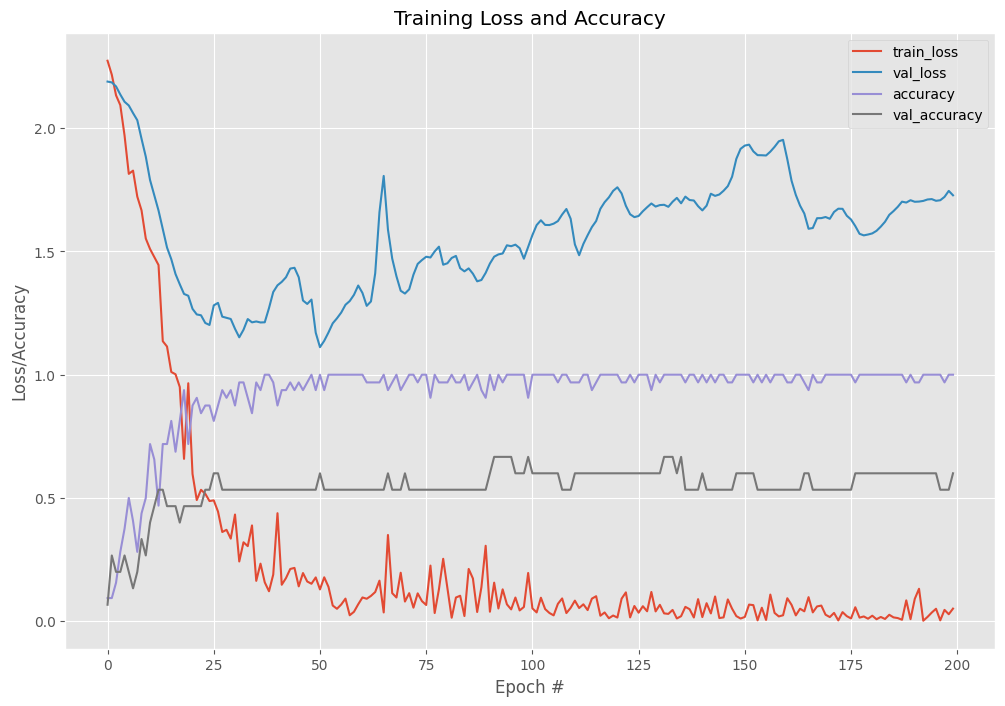

In [9]:
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.plot(N, hist.history['accuracy'], label="accuracy")
plt.plot(N, hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()